In [2]:
import pandas as pd # Pour le dataframe
import numpy as np # Pour la normalisation et calculs de moyenne
import matplotlib.pyplot as plt # Pour la visualisation

from PIL import Image

import librosa # Pour l'extraction des features et la lecture des fichiers wav
import librosa.display # Pour récupérer les spectrogrammes des audio
import librosa.feature

import os # C'est ce qui va nous permettre d'itérer sur les fichiers de l'environnement de travail

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV # Split de dataset et optimisation des hyperparamètres
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.ensemble import GradientBoostingClassifier # XGBoost
from sklearn.neighbors import KNeighborsClassifier # k-NN
from sklearn.svm import SVC # SVM
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report # Métriques pour la mesure de performances
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf # Pour le reseau de neurones simple et pour le CNN

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam
from keras.utils import to_categorical

from xgboost import XGBClassifier
from pprint import pprint

In [3]:
y, audio = librosa.load('./dataset/genres_original/blues/blues.00000.wav')


In [6]:
# Définissons la liste avec les genres :

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

# Création d'un dictionnaire avec les genres vide :
audio_files = {}


for g in genres:
  audio_files[g] = []

# Remplissage du dictionnaire en important les fichiers audio avec Librosa :
for g in genres:
  for audio in os.listdir(f'./dataset/genres_original/{g}'):
    audio_files[g].append(librosa.load(f'./dataset/genres_original/{g}/{audio}')[0])

In [7]:
def audio_pipeline(audio):
  features = []

  # Calcul du ZCR

  zcr = librosa.zero_crossings(audio)
  features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

  spectral_centroids = librosa.feature.spectral_centroid(y=audio)[0]
  features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point

  rolloff = librosa.feature.spectral_rolloff(y=audio)
  features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCC

  mfcc = librosa.feature.mfcc(y=audio)

  for x in mfcc:
    features.append(np.mean(x))


  return features

In [8]:
# Définissons les noms des colonnes

column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']

# Création d'un dataframe vide

df = pd.DataFrame(columns = column_names)

# On itère sur les audios pour remplir le dataframe

i = 0
for g in genres:
  for music in audio_files[g]:
    df.loc[i] = audio_pipeline(music)+[g]
    i+=1

In [11]:
df.to_csv('./music.csv', index = False)
selector = VarianceThreshold(threshold=(0.2))

selected_features = selector.fit_transform(df[['zcr', 'spectral_c', 'rolloff', 
                                                    'mfcc1', 'mfcc2', 'mfcc3',
                                                    'mfcc4','mfcc5', 'mfcc6', 
                                                    'mfcc7', 'mfcc8', 'mfcc9',
                                                    'mfcc10','mfcc11', 'mfcc12',
                                                    'mfcc13', 'mfcc14', 'mfcc15',
                                                    'mfcc16', 'mfcc17', 'mfcc18', 
                                                    'mfcc19', 'mfcc20']])

pd.DataFrame(selected_features)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,65186.0,2159.398277,4684.512534,-133.048981,105.738907,-22.158222,41.830692,-26.992498,19.118570,-26.566029,...,-10.814380,6.798669,-11.726956,4.397709,-6.031961,1.963063,-12.314546,3.256974,-8.806516,-3.369112
1,37202.0,1537.491387,3495.331816,-252.481781,104.945160,15.296445,42.687840,6.770454,21.611765,-1.311177,...,-1.961952,1.960265,-0.898227,7.762361,2.375863,1.779114,1.330541,3.615051,4.906600,-2.661052
2,57782.0,2155.845202,5011.532444,-109.140709,100.619659,-8.666454,47.354729,-6.568464,39.617756,-8.521923,...,-24.213415,6.583019,-8.652447,4.930261,-15.440971,1.534257,-6.754526,1.415189,-3.971741,3.287160
3,67763.0,2390.421814,5403.593286,-107.203255,88.492897,-4.171899,55.477848,-8.017713,38.413597,-6.413661,...,-19.248566,12.076122,-4.582267,3.784239,-16.988953,11.621647,-7.361444,-3.665254,-7.176823,1.973181
4,42435.0,1719.463366,3782.441191,-121.389793,122.498329,-14.734727,46.122139,-8.179257,20.172466,-19.171892,...,-6.722797,6.989505,-12.730549,5.058538,-5.185806,-1.453605,-7.042629,2.694212,3.409532,-2.713745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,104576.0,2510.073143,4735.123056,-47.043789,95.778229,-43.917881,52.071087,-22.550802,20.861921,-18.675611,...,-19.212608,9.452245,-12.584075,3.889403,-8.495848,6.268981,-9.121950,2.689798,-2.442532,-1.879326
995,91196.0,2568.395446,5364.140727,-203.344940,85.411697,-11.576986,54.754364,-11.617431,20.568466,-27.760782,...,-11.927793,4.132144,-3.998545,1.736056,-7.907963,4.303378,-11.239040,-1.184892,-5.032738,-2.364001
996,27231.0,1345.841383,2939.157324,-127.970421,134.440842,1.020514,54.439240,-0.454467,35.814579,-10.856740,...,-6.697597,11.041860,-8.380606,2.107745,-6.346206,0.991747,-5.323315,-0.843007,-4.661473,-4.788686
997,56499.0,1646.635926,3184.299435,-93.358856,137.467468,-45.092060,37.811539,-9.419834,12.594670,-7.480642,...,-2.459423,-9.579354,-3.167917,-5.562455,-7.494168,-5.683578,-2.015053,-3.879438,-6.208956,-8.088406


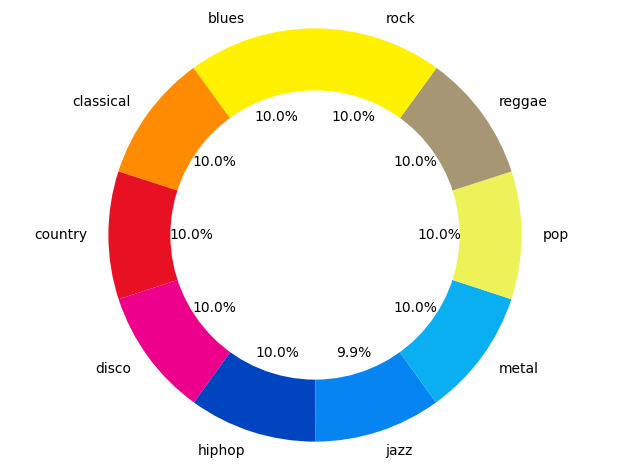

In [13]:
y = df['label']
values = np.unique(y,return_counts=True)[1]

labels = genres
sizes = values

# Choix des couleurs

colors =['#fff100','#ff8c00','#e81123','#ec008c','#0044bf','#0584f2','#0aaff1','#edf259','#a79674']
 
# Construction du diagramme et affichage des labels et des #fréquences en pourcentage

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

# Tracé du cercle au milieu

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Affichage du diagramme

ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [14]:
X = df[['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
           'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
           'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
           'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']]

y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Train score :  0.20400500625782228
Test score :  0.165


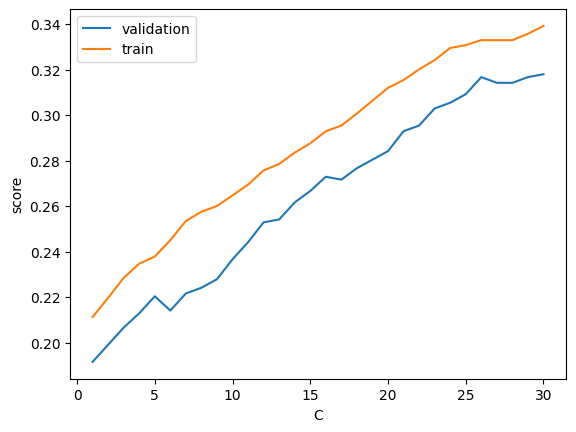

In [21]:
model_svm = SVC()
model_svm.fit(X_train, y_train)
print('Train score : ', model_svm.score(X_train,y_train))
print('Test score : ', model_svm.score(X_test,y_test))

k_3 = np.arange(1,31)
tr_score_3, val_score_3 = validation_curve(estimator=model_svm, X=X_train, y=y_train, param_name='C', param_range=k_3, cv = 5)

#5 splits sets de cross validation, on fait la moyenne des scores obtenus sur chacun des 5 splits

train = model_svm.predict(X_train)
predictions = model_svm.predict(X_test)

plt.plot(k_3, val_score_3.mean(axis = 1), label = 'validation')
plt.plot(k_3, tr_score_3.mean(axis = 1), label = 'train')

plt.ylabel('score')
plt.xlabel('C')
plt.legend()